<a href="https://colab.research.google.com/github/davidfague/Neural-Modeling/blob/main/Functional_Groups_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
is_colab = 'google.colab' in str(get_ipython())

In [2]:
if is_colab:
    !pip install neuron
    !pip install neuron_reduce
    !git clone https://github.com/davidfague/Neural-Modeling.git

In [3]:
if is_colab:
    %cd Neural-Modeling/

from Modules.synapse_generator import SynapseGenerator
from Modules.reduction import Reductor
from Modules.cell_model import CellModel
from Modules.spike_generator import SpikeGenerator
from Modules.complex_cell import build_L5_cell
from Modules.functional_group import FunctionalGroup, Cluster, generate_excitatory_functional_groups, generate_inhibitory_functional_groups
from Modules.cell_utils import get_segments_and_len_per_segment

import numpy as np
from functools import partial
import scipy.stats as st

from neuron import h

import ipywidgets as widgets
from ipywidgets import interactive_output, HBox, VBox, Layout
from Modules.plotting_utils import plot_morphology
import matplotlib.pyplot as plt
from Modules.plotting_utils import plot_simulation_results

In [4]:
random_state = np.random.RandomState(123)
neuron_r = h.Random()
neuron_r.MCellRan4()

3276331375.0

In [5]:
# Global vars
reduce_cell = False
expand_cable = False
choose_branches = 22

complex_cell_folder = 'complex_cells/L5PC/'

# Simulation params
h_celcius = 37 # Sim runtime
h_tstop = 2000
h_dt = 0.1 # Timestep (ms)

# Time vector for generating inputs
t = np.arange(0, h_tstop, 1)

## Build Complex Cell

### Compile modfiles

In [6]:
%%capture

# If this cell doesn't work, delete the compiled modfiles and restart the kernel
!nrnivmodl modfiles
h.load_file('stdrun.hoc')
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so') # load modfiles

### Build cell

In [7]:
complex_cell = build_L5_cell(complex_cell_folder)

h.celsius = h_celcius
h.v_init = complex_cell.soma[0].e_pas

# Sim runtime
h.tstop = h_tstop

# Timestep (ms)
h.dt = h_dt
h.steps_per_ms = 1 / h.dt

In [8]:
# Reductor(cell = complex_cell, method = 'lambda')

### Create Functional Groups and Synaptic Clusters

In [9]:
all_segments, all_len_per_segment, all_SA_per_segment,\
all_segments_center, soma_segments, soma_len_per_segment,\
soma_SA_per_segment, soma_segments_center, no_soma_segments,\
no_soma_len_per_segment, no_soma_SA_per_segment, no_soma_segments_center = get_segments_and_len_per_segment(complex_cell)

#### Excitatory

In [10]:
# Excitatory gmax distribution
exc_gmax_mean_0 = 0.2
exc_gmax_std_0 = 0.345

gmax_mean = np.log(exc_gmax_mean_0) - 0.5 * np.log((exc_gmax_std_0 / exc_gmax_mean_0) ** 2 + 1)
gmax_std = np.sqrt(np.log((exc_gmax_std_0 / exc_gmax_mean_0) ** 2 + 1))

# gmax distribution
def log_norm_dist(gmax_mean, gmax_std, size):
	s = float(np.clip(np.random.lognormal(gmax_mean, gmax_std, size), 0, 5))
	return s

gmax_exc_dist = partial(log_norm_dist, gmax_mean, gmax_std, size = 1)

# Excitatory firing rate distribution
def exp_levy_dist(alpha = 1.37, beta = -1.00, loc = 0.92, scale = 0.44, size = 1):
	return np.exp(st.levy_stable.rvs(alpha = alpha, beta = beta, loc = loc, scale = scale, size = size)) + 1e-15

In [11]:
spike_generator = SpikeGenerator()
synapse_generator = SynapseGenerator()

In [12]:
synaptic_density = 2.12
functional_group_span = 100
cluster_span = 10
synapses_per_cluster = 5

number_of_groups = int(sum(all_len_per_segment) / functional_group_span)

# Number of presynaptic cells
cells_per_group = int(functional_group_span*synaptic_density / synapses_per_cluster)

# Distribution of mean firing rates
mean_fr_dist = partial(exp_levy_dist, alpha = 1.37, beta = -1.00, loc = 0.92, scale = 0.44, size = 1)

# New list to change probabilty of exc functional group nearing soma
adjusted_no_soma_len_per_segment = []
for i, seg in enumerate(no_soma_segments):
    if h.distance(seg, complex_cell.soma[0](0.5)) < 100:
        adjusted_no_soma_len_per_segment.append(no_soma_len_per_segment[i] / 10)
    else:
        adjusted_no_soma_len_per_segment.append(no_soma_len_per_segment[i])

In [13]:
exc_functional_groups = generate_excitatory_functional_groups(all_segments = no_soma_segments,
                                                              all_len_per_segment = adjusted_no_soma_len_per_segment,
                                                              all_segments_centers = no_soma_segments_center,
                                                              number_of_groups = number_of_groups,
                                                              cells_per_group = cells_per_group,
                                                              synapses_per_cluster = synapses_per_cluster,
                                                              functional_group_span = functional_group_span,
                                                              cluster_span = cluster_span,
                                                              gmax_dist = gmax_exc_dist,
                                                              mean_fr_dist = mean_fr_dist,
                                                              spike_generator = spike_generator,
                                                              synapse_generator = synapse_generator,
                                                              t = t, random_state = random_state, 
                                                              neuron_r = neuron_r,
                                                              record = True, syn_mod = 'AMPA_NMDA')

In [14]:
exc_spikes = spike_generator.spike_trains

#### Inhibitory

In [15]:
synaptic_density = 0.22
cluster_span = 10

synapses = synaptic_density * sum(all_len_per_segment)
number_of_clusters = int(sum(all_len_per_segment) / cluster_span)
synapses_per_cluster = int(cluster_span * synaptic_density) # 12 # synapses/number_of_clusters
# synapses_per_node = 5
# number_of_clusters=int(synapses / (cluster_span * synaptic_density)) # number of presynaptic cells

# Proximal inh mean_fr distribution
mean_fr, std_fr = 16.9, 14.3
a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
proximal_inh_dist = partial(st.truncnorm.rvs, a = a, b = b, loc = mean_fr, scale = std_fr)

# Distal inh mean_fr distribution
mean_fr, std_fr = 3.9, 4.3
a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr
distal_inh_dist = partial(st.truncnorm.rvs, a = a, b = b, loc = mean_fr, scale = std_fr)

gmax_dist = 1.65 # need inh gmax distribution}
number_of_groups = 1

inhibitory_functional_groups = generate_inhibitory_functional_groups(cell = complex_cell,
                                                                     all_segments = all_segments,
                                                                     all_len_per_segment = all_len_per_segment,
                                                                     all_segments_centers = all_segments_center,
                                                                     number_of_groups = 1,
                                                                     cells_per_group = number_of_clusters,
                                                                     synapses_per_cluster = synapses_per_cluster,
                                                                     functional_group_span = functional_group_span,
                                                                     cluster_span = cluster_span,
                                                                     gmax_dist = gmax_dist,
                                                                     proximal_inh_dist = proximal_inh_dist,
                                                                     distal_inh_dist = distal_inh_dist,
                                                                     spike_generator = spike_generator,
                                                                     synapse_generator = synapse_generator,
                                                                     t = t, f_group_name_prefix = "diffuse_inh_",
                                                                     random_state = random_state, neuron_r = neuron_r,
                                                                     spike_trains_to_delay = exc_spikes, fr_time_shift = 4,
                                                                     record = True, syn_mod = 'GABA_AB')

In [16]:
# 300 soma inh synapses

number_of_clusters = 30 # Number of presynaptic cells
cluster_span = 10
synapses_per_cluster = 10

soma_inhibitory_functional_groups = generate_inhibitory_functional_groups(cell = complex_cell,
																		  all_segments = soma_segments,
																		  all_len_per_segment = soma_SA_per_segment,
																		  all_segments_centers = soma_segments_center,
																		  number_of_groups = 1,
																		  cells_per_group = number_of_clusters,
																		  synapses_per_cluster = synapses_per_cluster,
																		  functional_group_span = functional_group_span,
																		  cluster_span = cluster_span,
																		  gmax_dist = gmax_dist,
																		  proximal_inh_dist = proximal_inh_dist,
																		  distal_inh_dist = distal_inh_dist,
																		  spike_generator = spike_generator,
																		  synapse_generator = synapse_generator,
																		  t = t, f_group_name_prefix = "soma_inh_",
                                                                          random_state = random_state, neuron_r = neuron_r,
																		  spike_trains_to_delay = exc_spikes, fr_time_shift = 4,
																		  record = True, syn_mod = 'GABA_AB')


In [17]:
all_syns = []
for synapse_list in synapse_generator.synapses: # synapse_generator.synapses is a list of synapse lists
    for synapse in synapse_list:
        all_syns.append(synapse)

In [18]:
cell = CellModel(hoc_model = complex_cell, synapses = all_syns,
                 netcons = spike_generator.netcons, spike_trains = spike_generator.spike_trains,
                 spike_threshold = 10, random_state = random_state)

Generating 3D coordinates for L5PCtemplate[0].axon[0]
Generating 3D coordinates for L5PCtemplate[0].axon[1]


### Reduce Cell

In [19]:
# Reduce cell and store new things: can update CellModel module to do this stuff

def find_distal_sections(cell, region=str):
  '''
  Finds all terminal sections then gathers terminal apical sections that are greater than 800 microns from the soma in path length
  '''
  # find distal tuft sections:
  parent_sections=[]
  for sec in cell.all: # find non-terminal sections
    if sec.parentseg() is not None:
      if sec.parentseg().sec not in parent_sections:
        parent_sections.append(sec.parentseg().sec)
  terminal_sections=[]
  for sec in getattr(cell,region):  # check if the section is a terminal section and if it is apical tuft
    # print(h.distance(sec(0.5)))
    if region=='apic':
      if (sec not in parent_sections) and (h.distance(cell.soma[0](0.5),sec(0.5)) > 800):
        terminal_sections.append(sec)
    else:
      if (sec not in parent_sections):
        terminal_sections.append(sec)

      # print(sec, 'is a terminal section of the tuft'

  return terminal_sections

#reduce cell
if reduce_cell==True:
  #reduce complex dendritic trees to cables
  reduced_cell, synapses_list, netcons_list, txt_nr = subtree_reductor(complex_cell, synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)
  print("synapses_list after NR reduction:", synapses_list)
  if expand_cable==True:
    #expand cable to idealized dendritic trees
    sections_to_expand = [reduced_cell.hoc_model.apic[0]]
    furcations_x=[0.289004]
    nbranches=[choose_branches]
    reduced_dendritic_cell, synapses_list, netcons_list, txt_ce = cable_expander(reduced_cell, sections_to_expand, furcations_x, nbranches,
                                                                              synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)
    #remove basal dend 3d coordinates because they seem off
    for sec in reduced_dendritic_cell.dend:
      sec.pt3dclear()

    cell = CellModel(reduced_dendritic_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10) #NR model with apical cable converted to tree
    tufts=find_distal_sections(cell, 'apic')
    basals=find_distal_sections(cell, 'dend')
    cell._nbranch=len(tufts)

    print(cell._nbranch, "terminal tuft branches in reduced_dendritic_cell")
  else:
    #workaround since cell.all was not attribute (can update cell_model class to include this list formation)
    reduced_cell.all =[]
    for sec in [reduced_cell.soma]:
      reduced_cell.all.append(sec)
    for sec in [reduced_cell.apic]:
      reduced_cell.all.append(sec)
    for sec in reduced_cell.dend:
      reduced_cell.all.append(sec)
    for sec in reduced_cell.axon:
      reduced_cell.all.append(sec)
    #make apic sec a list (can update cell_model class to include this) (cell_model class expects cell.apic to be iterable)
    reduced_cell.apic=[reduced_cell.apic]
    #use cell_model python class
    cell=CellModel(reduced_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10) # neuron_reduce model
    tufts=cell.apic # Vm plot may return middle segment of trunk since it is the distal apical section.
    basals=find_distal_sections(cell, 'dend')
    cell._nbranch=len(tufts)
    print(cell._nbranch, "terminal tuft branches in reduced_cell")
else:
  basals=find_distal_sections(cell, 'dend')
  tufts=find_distal_sections(cell, 'apic')
  # cell = cell_model(complex_cell,synapses_list=synapses_list,netcons_list=netcons_list,spike_threshold = 10) # original cell
  # original cell should already be defined
  pass

### Prepare Simulation

In [20]:
import os

if is_colab:
    os.chdir('/content')
    if not os.path.isdir('Stylized-Single-Cell-and-Extracellular-Potential'):
        !git clone https://github.com/chenziao/Stylized-Single-Cell-and-Extracellular-Potential.git &> /dev/null
    os.chdir('Stylized-Single-Cell-and-Extracellular-Potential')
    %ls

cell_inference/  Stylized_Single_Cell_Extracellular_Potential_Tutorial.ipynb


In [20]:
from cell_inference.config import params, paths
from cell_inference.cells.activecell_axon import ReducedOrderL5Cell, ReducedOrderL5CellPassiveDendrite
from cell_inference.utils.currents.ecp import EcpMod
from cell_inference.utils.currents.recorder import Recorder
#from cell_inference.utils.plotting.plot_morphology import plot_morphology
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
from cell_inference.utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
from cell_inference.utils.metrics.measure_segment_distance import measure_segment_distance

In [21]:
# Record time points
t_vec = h.Vector(round(h.tstop / h.dt) + 1).record(h._ref_t)

# Record membrane voltage of all segments
V_rec = Recorder(cell.segments)

#### Add electrodes (Neuropixel)
A probe with 384 electrodes [https://www.neuropixels.org/probe](https://www.neuropixels.org/probe). The coordinates of each electrode is a row in the array printed below.

In [22]:
elec_pos = params.ELECTRODE_POSITION
ecp = EcpMod(cell, elec_pos, min_distance=params.MIN_DISTANCE)  # create an ECP object for extracellular potential

# coordinates (x, y, z) of electrodes
# print(params.ELECTRODE_POSITION.shape)
# print(params.ELECTRODE_POSITION)

#### Custom settings

Using the interactive tools below, you can change the position of the cell, and change the synapse strength and location on the cell.

**Cell position parameters (`x`, `y`, `z`, `alpha`, `h`, `phi`)**

Starting with soma at the origin, apical dendrite along y-axis, rotate and translate the cell to the desired position determined by 6 parameters. First, rotate alpha about the y-axis (spin), then rotate beta=arccos(h) about the x-axis (elevation), then rotate phi about the y-axis (azimuth). Finally translate the cell by (x,y,z).

Use the sliders to change the 6 position parameters. Use the sliders 'elev' and 'azim' to change view of the 3D plot.

Set azim to -90 in order to focus on zy plane view. 2D plot is of xy plane.

In [23]:
# Default position parameters
loc_param_default = [0., 0., 80., 0., 1., 0.]

# Default view
elev, azim = 10, 90

clr = []
clr.extend(['black' for i in range(len([cell.soma]))]) # Soma color
clr.extend(['red' for i in range(len(cell.dend))]) # Dend colors
clr.extend(['purple' for i  in range(len(cell.axon))]) # Axon colors
clr.extend(['blue']) # Trunk color
clr.extend(['green' for i in range(len(cell.apic)-1)]) # Branch colors

def interactive_plot(x, y, z, alpha, beta, phi, elev, azim):
    global loc_param
    loc_param = (x, y, z, np.pi / 180 * alpha, np.cos(np.pi / 180 * beta), np.pi / 180 * phi)
    _ = plot_morphology(cell = cell, electrodes = elec_pos, move_cell = loc_param, elev = -elev, azim = -azim, figsize = (12, 8), clr = clr)
    plt.show()

xslider = Layout(width = '500px')
yslider = Layout(height = '350px')
w_reset = widgets.Button(description = 'Reset', icon = 'history', button_style = 'primary')
w_x = widgets.FloatSlider(value=loc_param_default[0], min = -200, max = 200, step = 1, description='x (um)', continuous_update = False, readout_format = '.0f')
w_y = widgets.FloatSlider(value=loc_param_default[1], min=-1000, max=1000, step=1, description='y (um)', continuous_update=False, readout_format='.0f')
w_z = widgets.FloatSlider(value=loc_param_default[2], min=20, max=400, step=1, description='z (um)', continuous_update=False, readout_format='.0f')
w_alpha = widgets.FloatSlider(value=180/np.pi*loc_param_default[3], min=-180, max=180, step=1, description='alpha (deg)', continuous_update=False, readout_format='.0f')
w_beta = widgets.FloatSlider(value=180/np.pi*np.arccos(loc_param_default[4]), min=0, max=180, step=1, description='beta (deg)', continuous_update=False, readout_format='.0f')
w_phi = widgets.FloatSlider(value=180/np.pi*loc_param_default[5], min=-180, max=180, step=1, description='phi (deg)', continuous_update=False, readout_format='.0f')
w_elev = widgets.FloatSlider(value=-elev, min=-90, max=90, step=1, description='elev (deg)', continuous_update=False, readout_format='.0f', orientation='vertical', layout=yslider)
w_azim = widgets.FloatSlider(value=-azim, min=-180, max=180, step=1, description='azim (deg)', continuous_update=False, readout_format='.0f', layout=xslider)

def reset_default(*args):
    w_x.value, w_y.value, w_z.value = loc_param_default[:3]
    w_alpha.value = 180 / np.pi * loc_param_default[3]
    w_beta.value = 180 / np.pi * np.arccos(loc_param_default[4])
    w_phi.value = 180 / np.pi * loc_param_default[5]
    w_elev.value, w_azim.value = -elev, -azim
w_reset.on_click(reset_default)

out = interactive_output(interactive_plot, {'x': w_x, 'y': w_y, 'z': w_z, 'alpha': w_alpha, 'beta': w_beta, 'phi': w_phi, 'elev': w_elev, 'azim': w_azim})
ui = VBox([w_reset, HBox([ VBox([w_x, w_y, w_z]), VBox([w_alpha, w_beta, w_phi]) ]), HBox([ VBox([out, w_azim]), w_elev])])

display(ui)

In [24]:
def get_nested_property(seg, properties):
    if properties:
        property = properties[0]
        remaining_properties = properties[1:]
        if property in seg:
            if isinstance(seg[property], dict):
                if remaining_properties:
                    return get_nested_property(seg[property], remaining_properties)
                else:
                    return seg[property]
            elif len(remaining_properties) == 0:
                return seg[property]
            else:
                raise ValueError("Property list contains too many items for the depth of the target")
        else:
            raise ValueError(f"Property '{property}' not found in segment. Please specify a proper path in seg_info.")
    else:
        raise ValueError("Empty property list")

#identify the property being used #check cell.seg_info[0] for dictionary of properties (some are nested)
property_list = ['netcon_density_per_seg','exc']
# property_list = ['seg_elec_info','beta','passive_soma']
seg_prop = [get_nested_property(seg, property_list) for seg in cell.seg_info]

label = '_'.join(property_list)

# seg_prop=[seg['Center Z Coord'] for seg in cell.seg_info]
# seg_prop=[seg['seg_elec_info']['delta']['active_soma'] for seg in cell.seg_info]
# seg_prop=[seg['netcons_per_seg']['exc'] for seg in cell.seg_info]
seg_prop=np.array(seg_prop)
#normalized_seg_prop = (seg_prop - min(seg_prop)) / (max(seg_prop) - min(seg_prop))
# Define your percentile thresholds
lower, upper = np.percentile(seg_prop, [1, 99]) # you can adjust these percentiles to your needs
# Define normalization function based on these percentiles
robust_norm = plt.Normalize(vmin=lower, vmax=upper)
# Apply robust normalization to segment property
normalized_seg_prop = robust_norm(seg_prop)
cmap = plt.get_cmap('jet')
segment_colors = cmap(normalized_seg_prop)
# Create a ScalarMappable object to represent the colormap
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(seg_prop), vmax=max(seg_prop)))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=robust_norm)


def interactive_plot(x, y, z, alpha, beta, phi, elev, azim):
    global loc_param
    loc_param = (x, y, z, np.pi/180*alpha, np.cos(np.pi/180*beta), np.pi/180*phi)
    fig, ax = plot_morphology(cell=cell, electrodes=elec_pos, move_cell=loc_param, elev=-elev, azim=-azim, figsize=(12, 8),
                              clr = clr, seg_property = label, segment_colors = segment_colors, sm=sm)
    plt.show()

xslider = Layout(width='500px')
yslider = Layout(height='350px')
w_reset = widgets.Button(description='Reset', icon='history', button_style='primary')
w_x = widgets.FloatSlider(value=loc_param_default[0], min=-200, max=200, step=1, description='x (um)', continuous_update=False, readout_format='.0f')
w_y = widgets.FloatSlider(value=loc_param_default[1], min=-1000, max=1000, step=1, description='y (um)', continuous_update=False, readout_format='.0f')
w_z = widgets.FloatSlider(value=loc_param_default[2], min=20, max=400, step=1, description='z (um)', continuous_update=False, readout_format='.0f')
w_alpha = widgets.FloatSlider(value=180/np.pi*loc_param_default[3], min=-180, max=180, step=1, description='alpha (deg)', continuous_update=False, readout_format='.0f')
w_beta = widgets.FloatSlider(value=180/np.pi*np.arccos(loc_param_default[4]), min=0, max=180, step=1, description='beta (deg)', continuous_update=False, readout_format='.0f')
w_phi = widgets.FloatSlider(value=180/np.pi*loc_param_default[5], min=-180, max=180, step=1, description='phi (deg)', continuous_update=False, readout_format='.0f')
w_elev = widgets.FloatSlider(value=-elev, min=-90, max=90, step=1, description='elev (deg)', continuous_update=False, readout_format='.0f', orientation='vertical', layout=yslider)
w_azim = widgets.FloatSlider(value=-azim, min=-180, max=180, step=1, description='azim (deg)', continuous_update=False, readout_format='.0f', layout=xslider)

def reset_default(*args):
    w_x.value, w_y.value, w_z.value = loc_param_default[:3]
    w_alpha.value = 180 / np.pi * loc_param_default[3]
    w_beta.value = 180 / np.pi * np.arccos(loc_param_default[4])
    w_phi.value = 180 / np.pi * loc_param_default[5]
    w_elev.value, w_azim.value = -elev, -azim
w_reset.on_click(reset_default)

out = interactive_output(interactive_plot, {'x': w_x, 'y': w_y, 'z': w_z, 'alpha': w_alpha, 'beta': w_beta, 'phi': w_phi, 'elev': w_elev, 'azim': w_azim})
ui = VBox([ w_reset, HBox([ VBox([w_x, w_y, w_z]), VBox([w_alpha, w_beta, w_phi]) ]), HBox([ VBox([out, w_azim]), w_elev]) ])

display(ui)

In [25]:
#identify the property being used #check cell.seg_info[0] for dictionary of properties (some are nested)
property_list = ['netcon_density_per_seg','inh']
# property_list = ['seg_elec_info','beta','passive_soma']
seg_prop = [get_nested_property(seg, property_list) for seg in cell.seg_info]

label = '_'.join(property_list)

# seg_prop=[seg['Center Z Coord'] for seg in cell.seg_info]
# seg_prop=[seg['seg_elec_info']['delta']['active_soma'] for seg in cell.seg_info]
# seg_prop=[seg['netcons_per_seg']['exc'] for seg in cell.seg_info]
seg_prop=np.array(seg_prop)
#normalized_seg_prop = (seg_prop - min(seg_prop)) / (max(seg_prop) - min(seg_prop))
# Define your percentile thresholds
lower, upper = np.percentile(seg_prop, [1, 99]) # you can adjust these percentiles to your needs
# Define normalization function based on these percentiles
robust_norm = plt.Normalize(vmin=lower, vmax=upper)
# Apply robust normalization to segment property
normalized_seg_prop = robust_norm(seg_prop)
cmap = plt.get_cmap('jet')
segment_colors = cmap(normalized_seg_prop)
# Create a ScalarMappable object to represent the colormap
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(seg_prop), vmax=max(seg_prop)))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=robust_norm)


xslider = Layout(width='500px')
yslider = Layout(height='350px')
w_reset = widgets.Button(description='Reset', icon='history', button_style='primary')
w_x = widgets.FloatSlider(value=loc_param_default[0], min=-200, max=200, step=1, description='x (um)', continuous_update=False, readout_format='.0f')
w_y = widgets.FloatSlider(value=loc_param_default[1], min=-1000, max=1000, step=1, description='y (um)', continuous_update=False, readout_format='.0f')
w_z = widgets.FloatSlider(value=loc_param_default[2], min=20, max=400, step=1, description='z (um)', continuous_update=False, readout_format='.0f')
w_alpha = widgets.FloatSlider(value=180/np.pi*loc_param_default[3], min=-180, max=180, step=1, description='alpha (deg)', continuous_update=False, readout_format='.0f')
w_beta = widgets.FloatSlider(value=180/np.pi*np.arccos(loc_param_default[4]), min=0, max=180, step=1, description='beta (deg)', continuous_update=False, readout_format='.0f')
w_phi = widgets.FloatSlider(value=180/np.pi*loc_param_default[5], min=-180, max=180, step=1, description='phi (deg)', continuous_update=False, readout_format='.0f')
w_elev = widgets.FloatSlider(value=-elev, min=-90, max=90, step=1, description='elev (deg)', continuous_update=False, readout_format='.0f', orientation='vertical', layout=yslider)
w_azim = widgets.FloatSlider(value=-azim, min=-180, max=180, step=1, description='azim (deg)', continuous_update=False, readout_format='.0f', layout=xslider)

out = interactive_output(interactive_plot, {'x': w_x, 'y': w_y, 'z': w_z, 'alpha': w_alpha, 'beta': w_beta, 'phi': w_phi, 'elev': w_elev, 'azim': w_azim})
ui = VBox([ w_reset, HBox([ VBox([w_x, w_y, w_z]), VBox([w_alpha, w_beta, w_phi]) ]), HBox([ VBox([out, w_azim]), w_elev]) ])

display(ui)

TODO: Remove electrodes / plot electrodes behind cell if they're behind? Electrodes seem to always be on top of cell in the plot. Not sure if that is correct.

#### Run simulation and plot results

Run the codes below to simulate and display results everytime after you change the parameters above.

In [26]:
# Run simulation
h.run()

0.0

Plotting L5PCtemplate[0].soma[0](0.5) Voltage| y coordinate of this seg: 18.34367764312554
Plotting L5PCtemplate[0].apic[39](0.5) Voltage| y coordinate of this seg: 931.3700758816855
Plotting L5PCtemplate[0].apic[36](0.961538) Voltage| y coordinate of this seg: 931.3700758816855


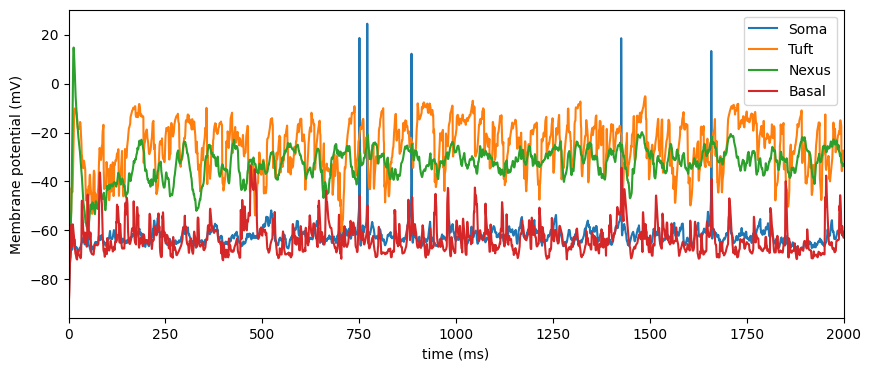

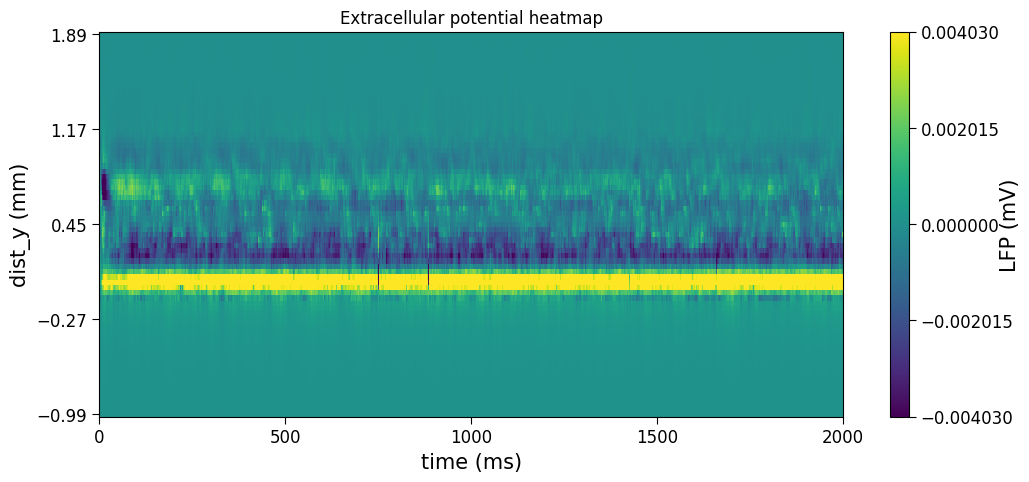

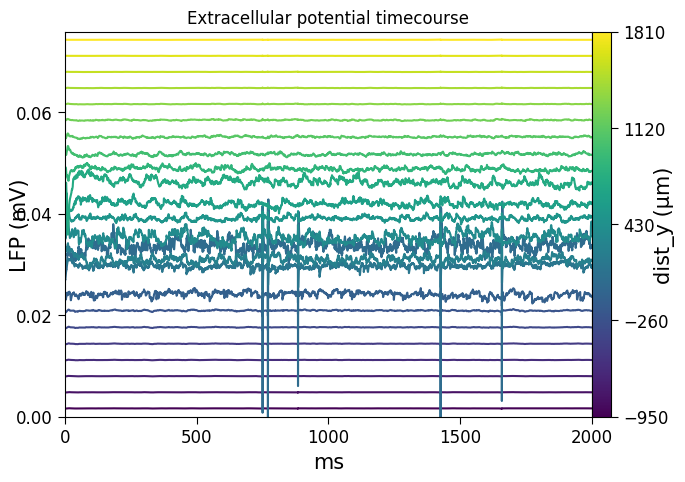

In [27]:
# Get results
t = t_vec.as_numpy().copy()  # time array (ms)
# Soma membrane potential
Vm = V_rec.as_numpy()

soma_seg_index = cell.segments.index(cell.soma[0](0.5))
axon_seg_index = cell.segments.index(cell.axon[-1](0.9))
basal_seg_index = cell.segments.index(basals[0](0.5))

# Choose a tuft to plot voltage
if (reduce_cell == True) and (expand_cable == True): # Dendritic reduced model
	tuft_seg_index = tuft_seg_index=cell.segments.index(tufts[0](0.5)) # Otherwise tufts[0] will be truly tuft section and the segment in the middle of section is fine
	nexus_seg_index = cell.segments.index(cell.apic[0](0.99))
elif (reduce_cell == True) and (expand_cable == False): # NR model
	tuft_seg_index = cell.segments.index(tufts[0](0.9)) # tufts[0] will be the cable that is both trunk and tuft in this case, so we have to specify near end of cable
	nexus_seg_index = cell.segments.index(cell.apic[0](0.289004))
else: # Complex cell
	tuft_seg_index=cell.segments.index(tufts[0](0.5)) # Otherwise tufts[0] will be truly tuft section and the segment in the middle of section is fine
	nexus_seg_index=cell.segments.index(cell.apic[36](0.961538))

print("Plotting",cell.segments[soma_seg_index],"Voltage| y coordinate of this seg:", cell.seg_coords['pc'][soma_seg_index][1])
print("Plotting",cell.segments[tuft_seg_index],"Voltage| y coordinate of this seg:", cell.seg_coords['pc'][tuft_seg_index][1])
print("Plotting",cell.segments[nexus_seg_index],"Voltage| y coordinate of this seg:", cell.seg_coords['pc'][tuft_seg_index][1])

# lfp array
lfp = ecp.calc_ecp(move_cell=loc_param).T  # unit: mV

# plot membrane voltage at given segments and plot lfp from extracellular probe
plot_simulation_results(t, Vm, soma_seg_index, axon_seg_index, basal_seg_index, tuft_seg_index, nexus_seg_index,
						loc_param, lfp, elec_pos, plot_lfp_heatmap, plot_lfp_traces)

In [28]:
np.array(cell.spikes)

array([ 750.6,  770.9,  885.1, 1426.2, 1658.7])

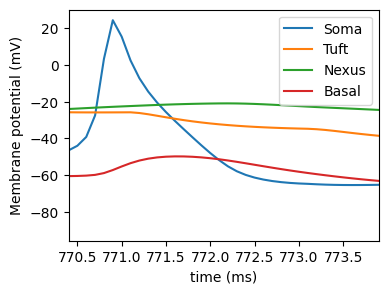

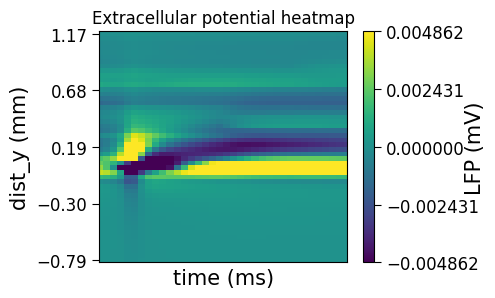

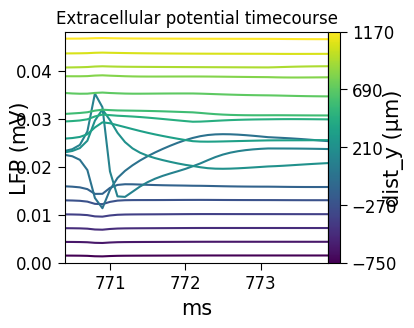

In [29]:
# zoom in on action potential in LFP
# show LFP 0.5 ms before spike to 3 ms after spike
AP_time = cell.spikes[1] # ms #TODO: check
before_AP = AP_time - 0.5 # ms
after_AP = AP_time + 3 # ms
xlim = [before_AP, after_AP]
ylim = [-800, 1200] # can try doing min and max of seg coords

plot_simulation_results(t, Vm, soma_seg_index, axon_seg_index, basal_seg_index, tuft_seg_index, nexus_seg_index,
						loc_param, lfp, elec_pos, plot_lfp_heatmap, plot_lfp_traces, xlim=xlim, ylim=ylim, figsize=(4,3))

### Store Simulation Data

In [ ]:
# exc_spike_trains=[]
# inh_spike_trains=[]
# for i,synapse in enumerate(cell.synapses):
#   seg=synapse.get_segment()
#   syn=synapse.synapse_neuron_obj
#   if "AMPA" in str(syn):
#     exc_spike_trains.append(spike_generator.spike_trains[i])
#   elif "GABA" in str(syn):
#     inh_spike_trains.append(spike_generator.spike_trains[i])

In [ ]:
# for i,spike_train in enumerate(inh_spike_trains):
#   y=np.zeros(len(spike_train))+i
#   plt.scatter(spike_train,y)

In [ ]:
# for i,spike_train in enumerate(exc_spike_trains):
#   y=np.zeros(len(spike_train))*i
#   plt.scatter(spike_train,y)

In [ ]:
# close_exc_syns=[]
# close_inh_syns=[]
# for synapse in cell.synapses:
#   seg=synapse.get_segment()
#   syn=synapse.synapse_neuron_obj
#   if "AMPA" in str(syn):
#     if h.distance(seg,cell.soma[0](0.5))<200:
#       close_exc_syns.append(syn)
#   elif "GABA" in str(syn):
#     if h.distance(seg,cell.soma[0](0.5))<200:
#       close_inh_syns.append(syn)
# print(len(close_exc_syns))
# print(len(close_inh_syns))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd ..

In [ ]:
%cd drive/MyDrive/

In [ ]:
data_dict=cell.get_recorder_data() #also creates directory # update to remove folder first

Above code will print if it saved successfully

In [ ]:
cell.write_seg_info_to_csv()